# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

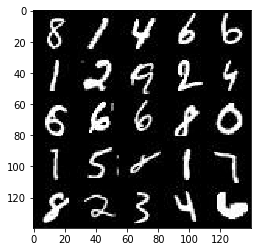

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

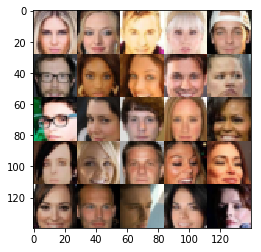

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height,image_channels)))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
            alpha = 0.2
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            # 16x16x32

            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 8x8x128

            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            flat = tf.reshape(relu3, (-1, 4*4*256))
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)

            return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator',reuse=not is_train):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        """
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        """
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
   
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images * 2, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images * 2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                  

        #saver.save(sess, './checkpoints/generator.ckpt')

        
    return losses, samples
    
    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6263... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 2.2823... Generator Loss: 1.6222
Epoch 1/2... Discriminator Loss: 1.8300... Generator Loss: 0.7262
Epoch 1/2... Discriminator Loss: 1.8271... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 1.3592
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 1.1973
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 1.0935


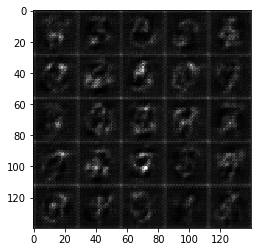

Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 1.2600
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 1.3714


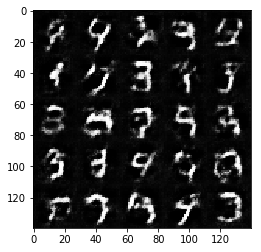

Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.9845
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 1.1348
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 1.0076
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 1.0115


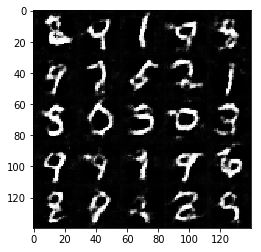

Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.6285... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 1.9313... Generator Loss: 0.2020
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.8448


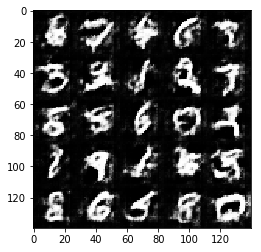

Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.3949
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 2.4972... Generator Loss: 0.1126
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.6201... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.5031


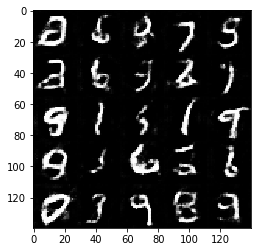

Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 0.4050
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.4609
Epoch 2/2... Discriminator Loss: 1.5921... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 1.5930... Generator Loss: 1.1625


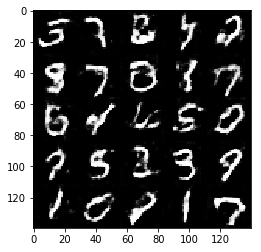

Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 1.5847... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.4756
Epoch 2/2... Discriminator Loss: 1.9829... Generator Loss: 0.1979
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.7062


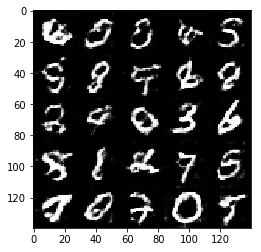

Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.7749
Epoch 2/2... Discriminator Loss: 1.7752... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 1.7043... Generator Loss: 0.2626
Epoch 2/2... Discriminator Loss: 1.5697... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 1.6235... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.5689


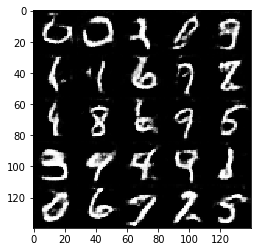

Epoch 2/2... Discriminator Loss: 1.7048... Generator Loss: 0.2588
Epoch 2/2... Discriminator Loss: 1.5703... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.4292
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.6317... Generator Loss: 0.3190
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.3445
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.7787... Generator Loss: 1.7506


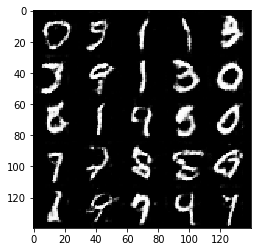

Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 2.3242... Generator Loss: 1.8910
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.3711


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1384... Generator Loss: 0.0234
Epoch 1/1... Discriminator Loss: 2.6781... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 2.2405... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 2.0422... Generator Loss: 0.2418
Epoch 1/1... Discriminator Loss: 1.9901... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.7416... Generator Loss: 0.3696
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 0.6295


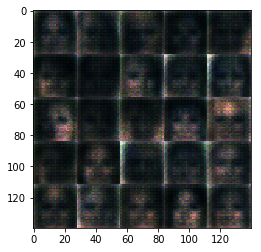

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6266


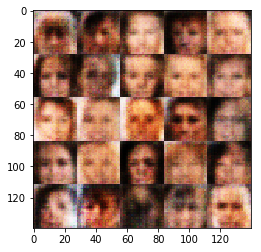

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6497


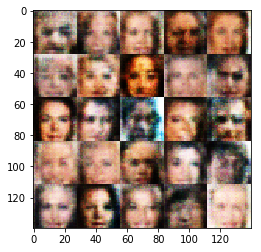

Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6014


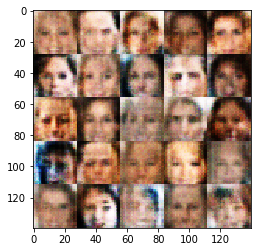

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.6923


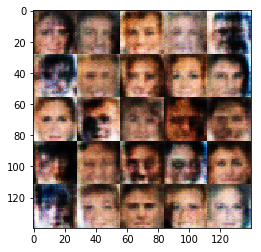

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7238


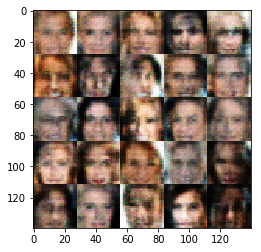

Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6042


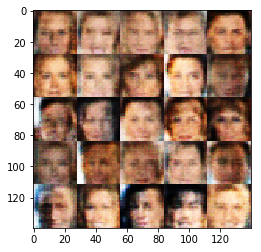

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6334


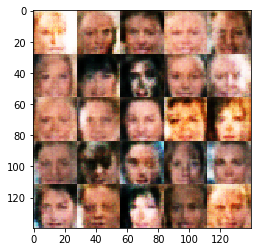

Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6588


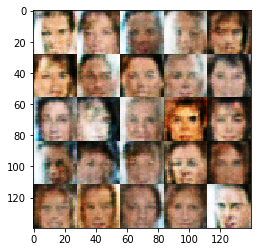

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7239


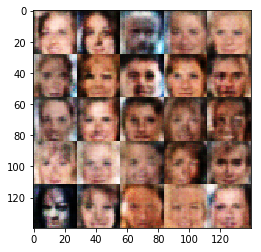

Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7103


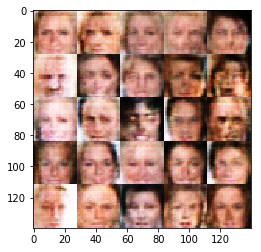

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7994


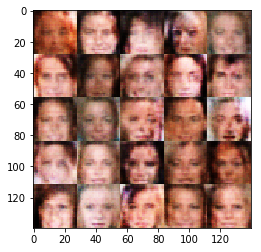

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7087


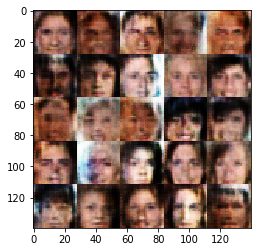

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7537


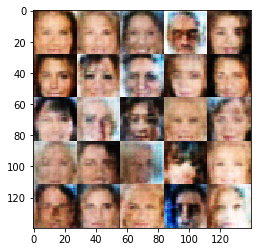

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7126


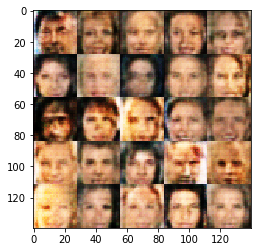

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6955


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.